In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e6/sample_submission.csv
/kaggle/input/playground-series-s3e6/train.csv
/kaggle/input/playground-series-s3e6/test.csv


## TODO
- Understanding the data (Missing values, unique values, categorial and continous features)
- Distribution train vs test, finding outliers
- Outliers deletion
- Models
- Evaluation (RMSE)

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

colors = sns.color_palette("pastel6")

## Understanding the data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv')
print(f'Train Columns : {train.columns}\n Train Shape : {train.shape}\n Test Columns : {test.columns}\n Test Shape : {test.shape}')

Train Columns : Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
 Train Shape : (22730, 18)
 Test Columns : Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')
 Test Shape : (15154, 17)


In [5]:
train.describe()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,22730.000000,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,11364.500000,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,6561.730145,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,0.000000,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,5682.250000,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,11364.500000,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,17046.750000,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,22729.000000,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


In [6]:
test.describe()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000
mean,30306.500000,45729.407681,47.874951,0.483371,0.445361,46.401148,50185.582750,5.616933,5.602547,2006.225485,0.472219,0.463442,5299.415468,5057.506599,525.091065,0.463178,5.095618
std,4374.727325,29200.142520,28.164077,0.499740,0.497022,27.000547,31227.690126,2.727914,2.718316,8.156347,0.499244,0.498678,2980.156234,2928.004147,268.504745,0.498659,3.049174
min,22730.000000,69.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,8.000000,1.000000,8.000000,0.000000,0.000000
25%,26518.250000,19189.000000,25.000000,0.000000,0.000000,25.000000,23141.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,3114.000000,2567.000000,294.250000,0.000000,2.000000
50%,30306.500000,43802.000000,46.000000,0.000000,0.000000,44.000000,50693.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,5017.000000,501.000000,0.000000,5.000000
75%,34094.750000,70898.000000,75.000000,1.000000,1.000000,69.000000,76264.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7739.000000,7650.750000,757.000000,1.000000,8.000000
max,37883.000000,99999.000000,100.000000,1.000000,1.000000,100.000000,977950.000000,10.000000,10.000000,2021.000000,1.000000,1.000000,89016.000000,38535.000000,1000.000000,1.000000,10.000000


#### We can see some strange values already like the max for the squareMeters between the 2 datasets. We are gonna need to look at the distributions and see if they are some outliers.

In [7]:
print(f'Missing values train dataset : {train.isnull().sum().sum()}')
print(f'Missing values test dataset : {test.isnull().sum().sum()}')

Missing values train dataset : 0
Missing values test dataset : 0


In [8]:
print(f'Unique values train dataset : \n{train.nunique()}\n')
print(f'Unique values test dataset : \n{test.nunique()}')

Unique values train dataset : 
id                   22730
squareMeters          7319
numberOfRooms          100
hasYard                  2
hasPool                  2
floors                 101
cityCode              7810
cityPartRange           10
numPrevOwners           10
made                    33
isNewBuilt               2
hasStormProtector        2
basement              4903
attic                 5167
garage                 896
hasStorageRoom           2
hasGuestRoom            11
price                 7421
dtype: int64

Unique values test dataset : 
id                   15154
squareMeters          6433
numberOfRooms          100
hasYard                  2
hasPool                  2
floors                 100
cityCode              6632
cityPartRange           10
numPrevOwners           10
made                    32
isNewBuilt               2
hasStormProtector        2
basement              4216
attic                 4558
garage                 881
hasStorageRoom           2
hasGues

### Categorical and continuous values :
- Categorical (<25 unique values/not continuous) : hasYard, hasPool, cityPartRange, numPrevOwners, made (to format by regrouping by dates), isNewBuilt, hasStormProtector, hasStorageRoom, hasGuestRoom, cityCode (to format because a lot of value not in test dataset and vice versa)
- Continuous : squareMeters, numberOfRooms, floors, basement, attic, garage

In [9]:
categoricals = ['hasYard','hasPool','cityPartRange','numPrevOwners','made','isNewBuilt','hasStormProtector','hasStorageRoom','hasGuestRoom','cityCode']
continuous = ['squareMeters', 'numberOfRooms', 'floors', 'basement', 'attic', 'garage']

 ## Distribution train vs test, finding outliers

### Continuous features

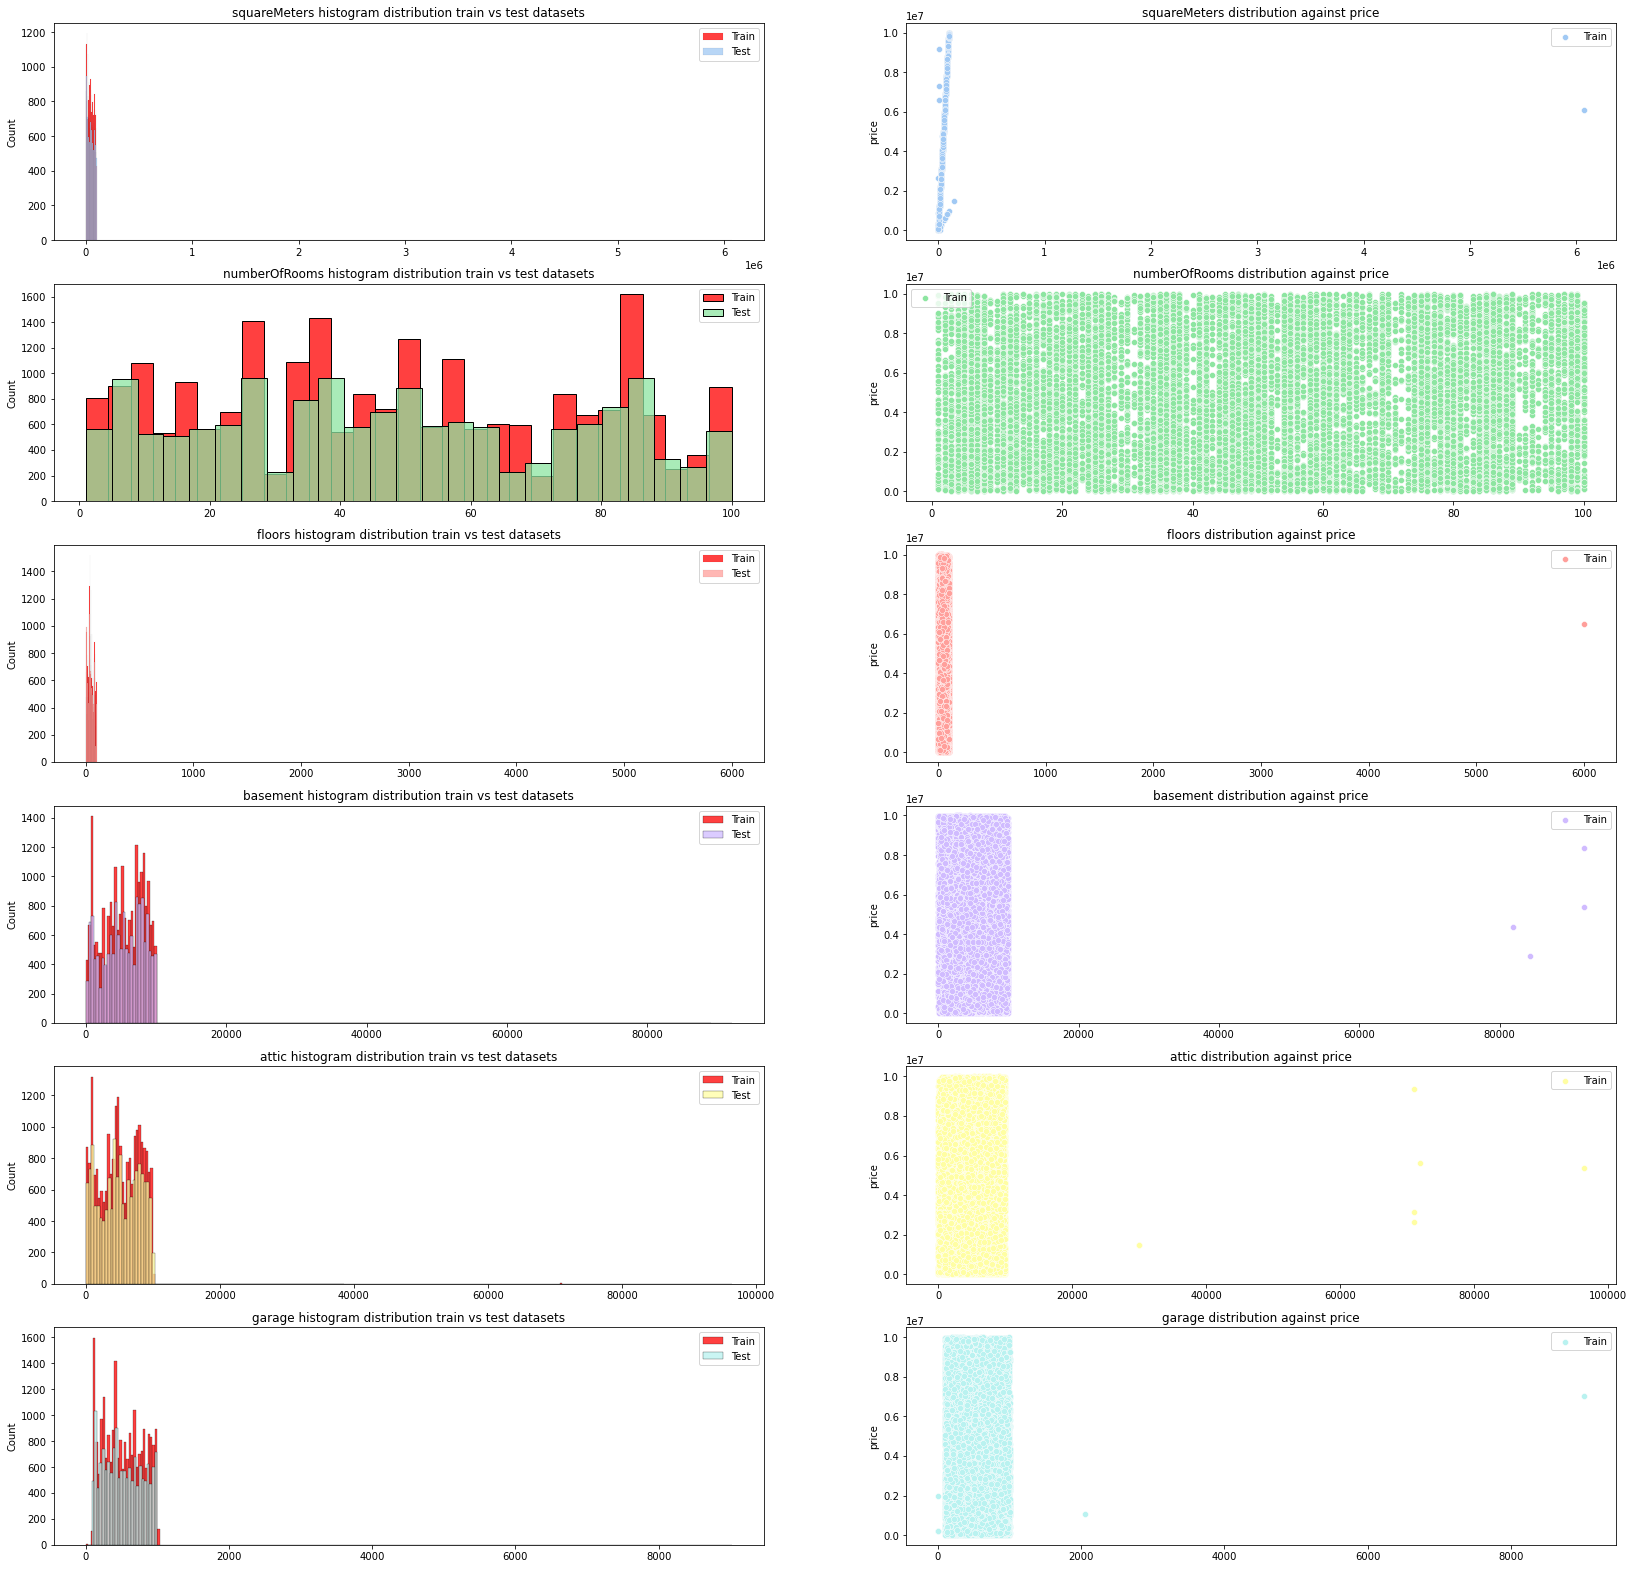

In [10]:
fig, ax = plt.subplots(6, 2, figsize=(28, 28))

for i, col in enumerate(continuous):  
    sns.histplot(train[col], label='Train', ax=ax[i][0], color='red')
    sns.histplot(test[col], label='Test', ax=ax[i][0], color=colors[i])
    ax[i][0].set_title(f"{col} histogram distribution train vs test datasets")
    ax[i][0].set_xlabel(None)
    ax[i][0].legend()
    
    sns.scatterplot(x=train[col], y=train['price'], ax=ax[i][1], color=colors[i], label='Train')
    ax[i][1].set_title(f"{col} distribution against price")
    ax[i][1].set_xlabel(None)
    ax[i][1].legend()

#### We can see some outliers on 5 out of 6 of the continuous features. The attic has the most outliers (6).
#### Looking for these values by fetching the 6 biggest values.

In [11]:
print('Train dataset')
for i, col in enumerate(continuous):
    print(f'{col} : {train[col].sort_values(ascending=False)[:6].values} \n')
    
print('\nTest dataset')
for i, col in enumerate(continuous):
    print(f'{col} : {test[col].sort_values(ascending=False)[:6].values} \n')

Train dataset
squareMeters : [6071330  146181   99985   99985   99985   99985] 

numberOfRooms : [100 100 100 100 100 100] 

floors : [6000  100  100  100  100  100] 

basement : [91992 91978 84333 81851 10000 10000] 

attic : [96381 71965 71024 71001 71001 30000] 

garage : [9017 2048 1000 1000 1000 1000] 


Test dataset
squareMeters : [99999 99985 99985 99985 99918 99913] 

numberOfRooms : [100 100 100 100 100 100] 

floors : [100 100 100 100 100 100] 

basement : [89016 84333 26132 10000 10000 10000] 

attic : [38535 30000 13779 10000 10000 10000] 

garage : [1000 1000 1000 1000 1000 1000] 



#### For each features we are going to drop extreme values that are not present in the test dataset.
- squareMeters : values > 100000
- numberOfRooms : no values
- floors : values > 100
- basement : no values
- attic : values > 40000
- garage : values > 1000

## Outliers deletion

In [12]:
train.drop(index=train[train['squareMeters']>100000].index, inplace=True)
train.drop(index=train[train['floors']>100].index, inplace=True)
train.drop(index=train[train['attic']>40000].index, inplace=True)
train.drop(index=train[train['garage']>1000].index, inplace=True)

### Checking distribution after outliers deletion

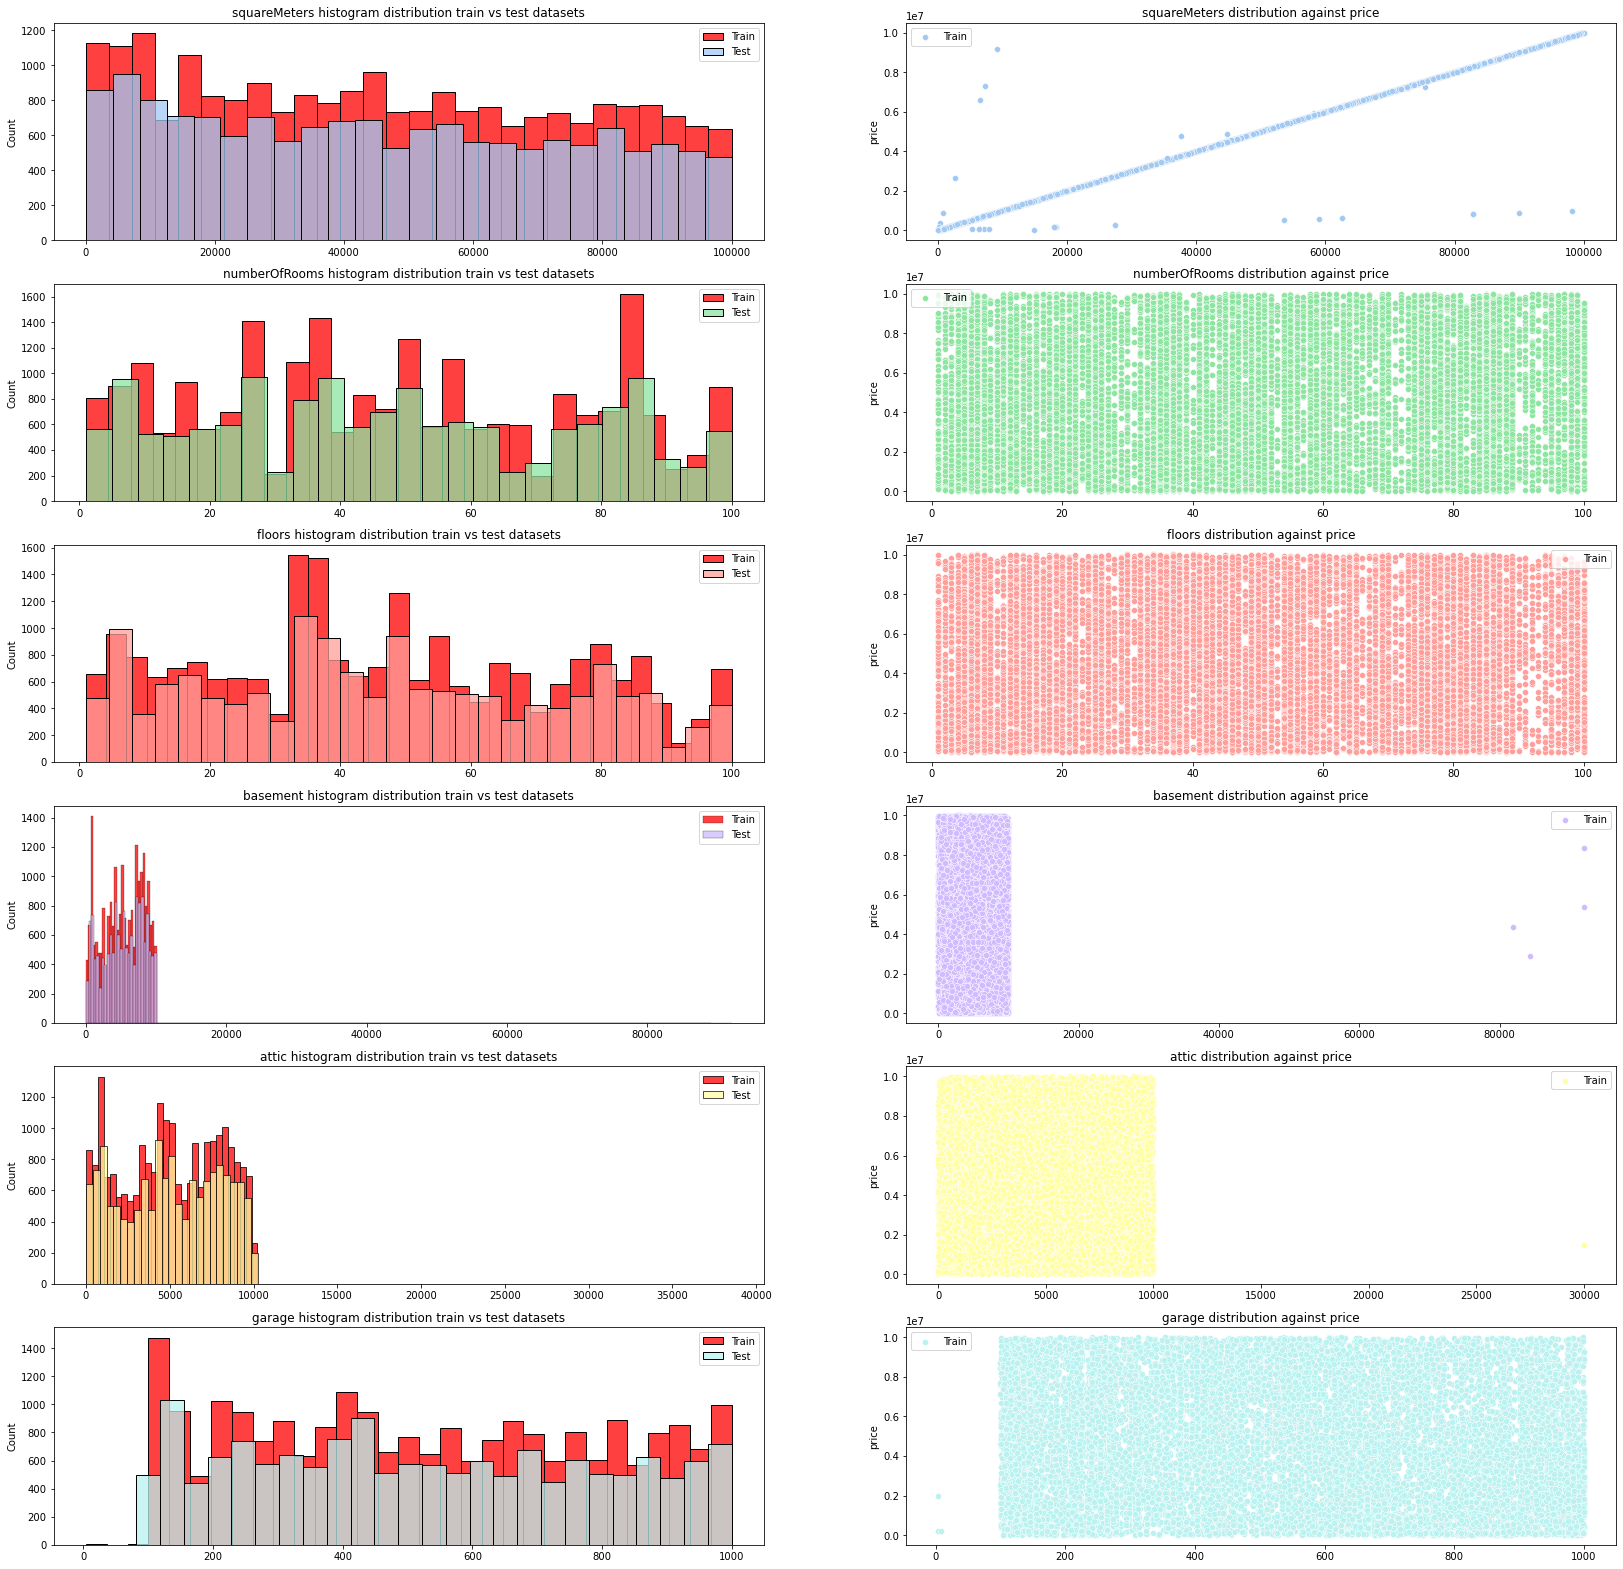

In [13]:
fig, ax = plt.subplots(6, 2, figsize=(28, 28))

for i, col in enumerate(continuous):  
    sns.histplot(train[col], label='Train', ax=ax[i][0], color='red')
    sns.histplot(test[col], label='Test', ax=ax[i][0], color=colors[i])
    ax[i][0].set_title(f"{col} histogram distribution train vs test datasets")
    ax[i][0].set_xlabel(None)
    ax[i][0].legend()
    
    sns.scatterplot(x=train[col], y=train['price'], ax=ax[i][1], color=colors[i], label='Train')
    ax[i][1].set_title(f"{col} distribution against price")
    ax[i][1].set_xlabel(None)
    ax[i][1].legend()

#### The distributions of continuous features are now more similar between train and test dataset.

### Categorical features

#### Transforming the years into years ranges

In [31]:
def years_into_range(year):
    if year >= 1990 and year <= 1995:
        return '1990-1995'
    elif year >= 1996 and year <= 2000:
        return '1996-2000'
    elif year >= 2001 and year <= 2005:
        return '2001-2005'
    elif year >= 2006 and year <= 2010:
        return '2006-2010'
    elif year >= 2011 and year <= 2015:
        return '2011-2015'
    elif year >= 2016 and year <= 2021:
        return '2016-2021'

train['made_ranges'] = train['made'].apply(lambda year: years_into_range(year))
test['made_ranges'] = test['made'].apply(lambda year: years_into_range(year))
display(train['made_ranges'].value_counts())

1996-2000    6306
2016-2021    4235
2006-2010    4046
2011-2015    3157
2001-2005    2895
1990-1995    2076
Name: made_ranges, dtype: int64

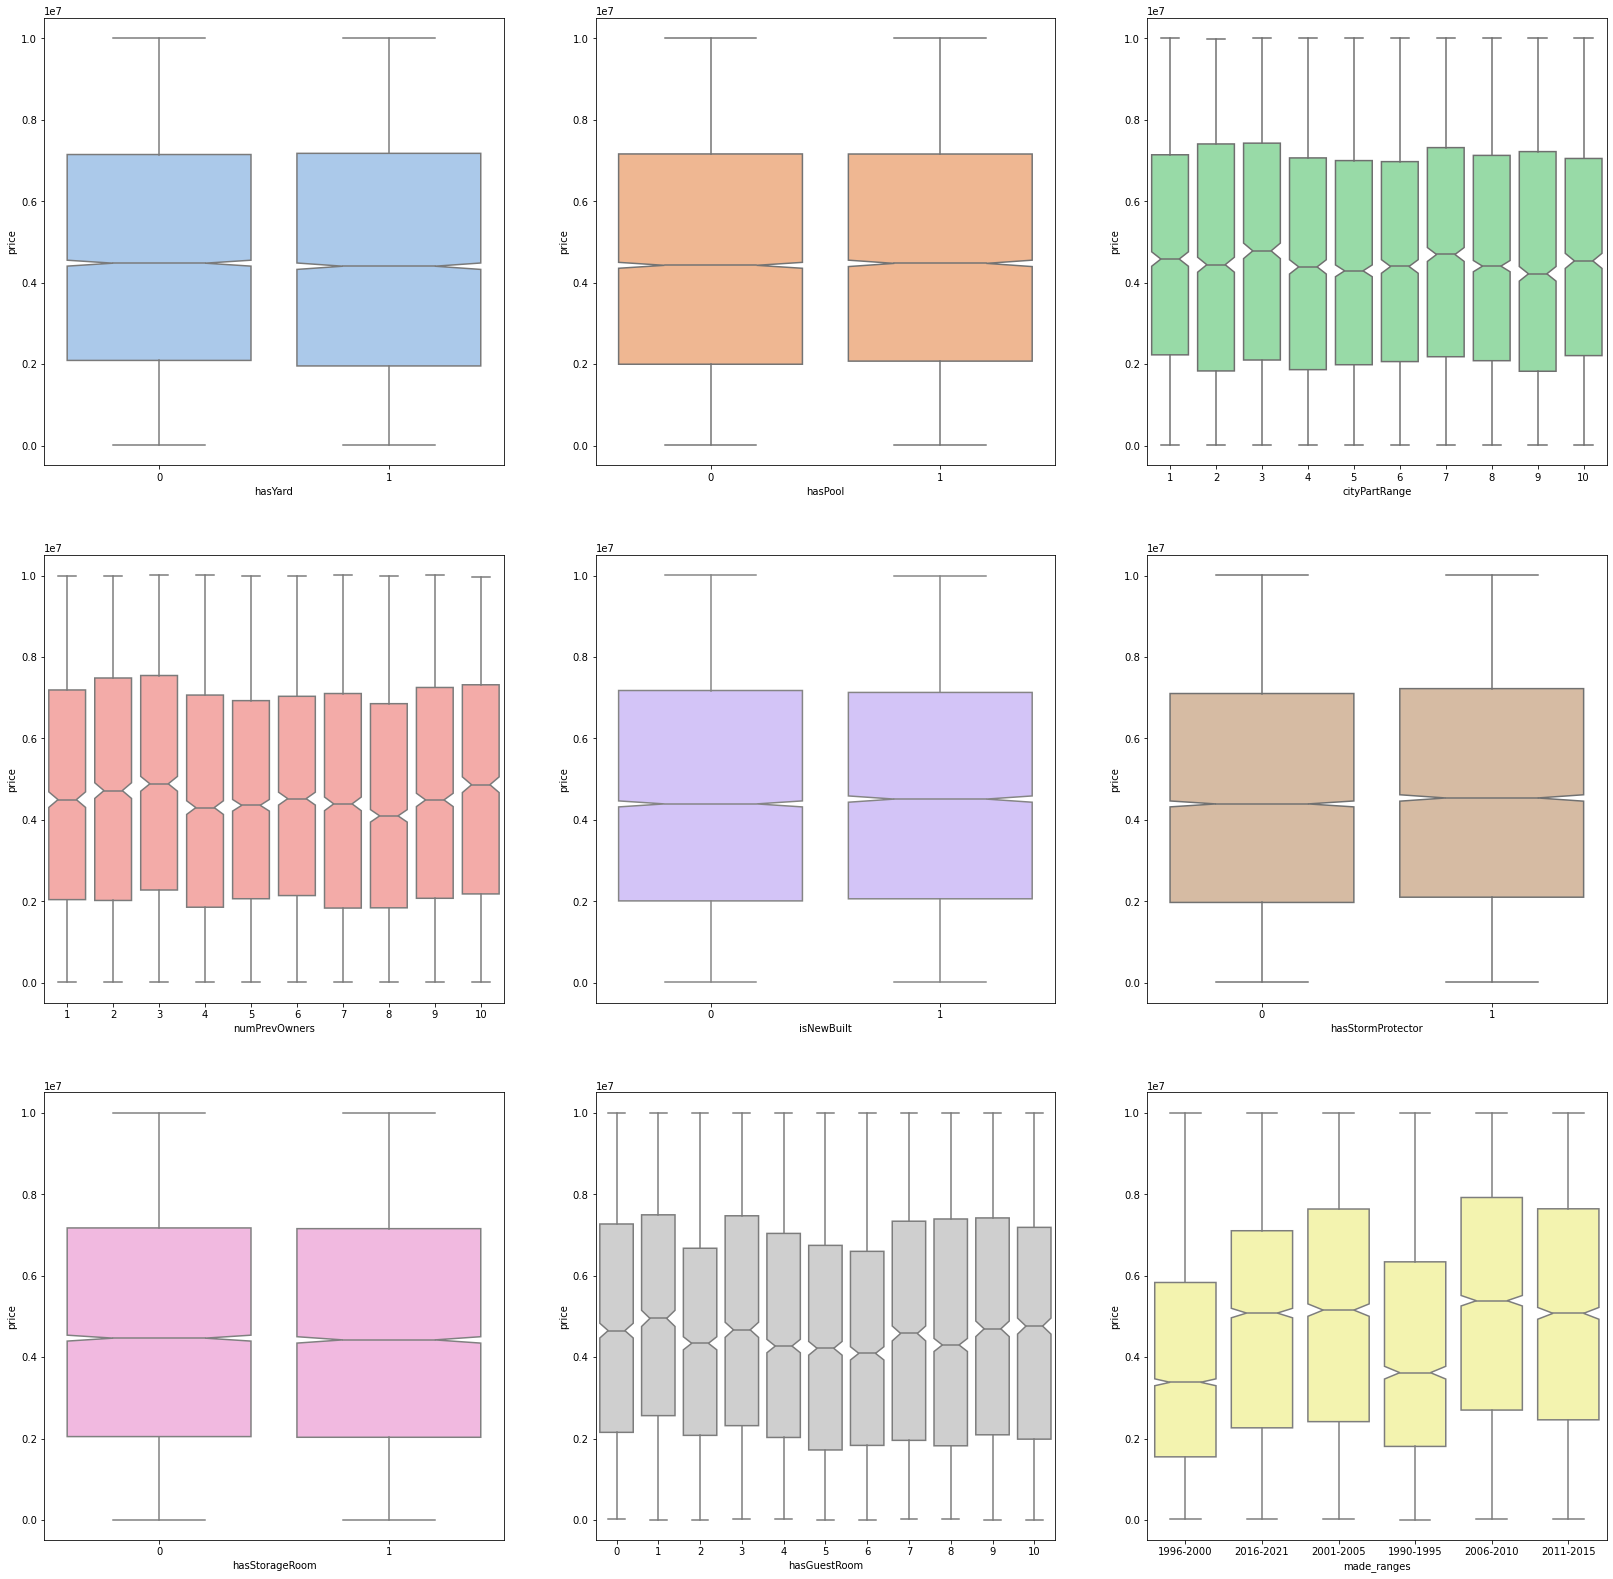

In [15]:
cols = [feature for feature in categoricals if feature not in ['cityCode', 'made']] + ['made_ranges']
fig, ax = plt.subplots(3, 3, figsize=(28, 28))
ax = ax.flatten()
for i, col in enumerate(cols):
     sns.boxplot(
        x=train[col],
        y=train['price'],
        ax=ax[i],
        color=sns.color_palette("pastel")[i],
        notch=True
    )

#### Hot encoding year ranges

In [16]:
train = pd.get_dummies(train, prefix=['made_ranges'])
test = pd.get_dummies(test, prefix=['made_ranges'])

In [17]:
train.dtypes

id                         int64
squareMeters               int64
numberOfRooms              int64
hasYard                    int64
hasPool                    int64
floors                     int64
cityCode                   int64
cityPartRange              int64
numPrevOwners              int64
made                       int64
isNewBuilt                 int64
hasStormProtector          int64
basement                   int64
attic                      int64
garage                     int64
hasStorageRoom             int64
hasGuestRoom               int64
price                    float64
made_ranges_1990-1995      uint8
made_ranges_1996-2000      uint8
made_ranges_2001-2005      uint8
made_ranges_2006-2010      uint8
made_ranges_2011-2015      uint8
made_ranges_2016-2021      uint8
dtype: object

## Models

In [32]:
X = train.drop(columns=['id','price','made']) #dropping the id, price and made (years)
y = train.price
print(f'X :{X.columns.values}\n\n y : {y.name}')

X_submission = test.drop(columns=['id','made'])


X :['squareMeters' 'numberOfRooms' 'hasYard' 'hasPool' 'floors' 'cityCode'
 'cityPartRange' 'numPrevOwners' 'isNewBuilt' 'hasStormProtector'
 'basement' 'attic' 'garage' 'hasStorageRoom' 'hasGuestRoom'
 'made_ranges_1990-1995' 'made_ranges_1996-2000' 'made_ranges_2001-2005'
 'made_ranges_2006-2010' 'made_ranges_2011-2015' 'made_ranges_2016-2021'
 'made_ranges']

 y : price


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

### XGBRegressor

In [20]:
xgbReg = XGBRegressor(n_estimators=200)
xgbReg.fit(X_train, y_train)
xgbRegPrediction = xgbReg.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, xgbRegPrediction))
print(rmse)

111984.90689144857


### RandomForestRegressor

109667.40738648527
105570.29935540674
105535.76606963629
105349.84274613389
104577.84913585328
104847.09836530397
105299.54417331265


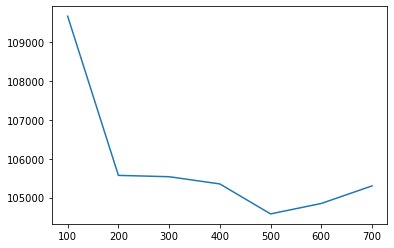

In [33]:
def scoring_estimators(n_estimators):
    rdForestReg = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
    rdForestReg.fit(X_train, y_train)
    rdForestRegPrediction = rdForestReg.predict(X_test)
    return sqrt(mean_squared_error(y_test, rdForestRegPrediction))

results = {}
for j in range(100, 800, 100):
    results[j] = scoring_estimators(j)
    print(results[j])
    
plt.plot(list(results.keys()), list(results.values()))
plt.show()

- n_estimators = 500

In [22]:
rdForestReg = RandomForestRegressor(n_estimators = 500, min_samples_leaf=1,max_features="auto",random_state = 0)
rdForestReg.fit(X_train, y_train)
rdForestRegPrediction = rdForestReg.predict(X_test)   
rmse = sqrt(mean_squared_error(y_test, rdForestRegPrediction))
print(rmse)

104577.84913585328


### Submission prediction test dataset

In [23]:
prediction_submission = {'price' : rdForestReg.predict(X_submission)}

In [24]:
df_submission = pd.DataFrame(data=prediction_submission, index=test['id'])
print(df_submission.shape)
print(df_submission.head())

(15154, 1)
              price
id                 
22730  4.767224e+06
22731  6.217784e+06
22732  9.059967e+06
22733  1.645092e+06
22734  6.759635e+06


In [25]:
df_submission.to_csv('submission.csv')